In [3]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
sys.path.append(DATA_DIR)
# imported from JNE project
import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Okay, now a stim data loader...
d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    # held_in_session_ids=["MonkeyG_20150914_Session1_S1", "MonkeyG_20150915_Session2_S1"],
    # batch_size=15000,
    # held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"],   # 10ms, 10ms, 10ms
    # held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
    # held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
    batch_size=60000,
    held_in_session_ids=[
        "MonkeyG_20150914_Session1_S1",
        "MonkeyG_20150915_Session3_S1",
        "MonkeyG_20150915_Session5_S1",
        "MonkeyG_20150916_Session4_S1",
        "MonkeyG_20150917_Session1_M1",
        "MonkeyG_20150917_Session1_S1",
        "MonkeyG_20150917_Session2_M1",
        "MonkeyG_20150917_Session2_S1",
        "MonkeyG_20150921_Session3_S1",
        "MonkeyG_20150921_Session5_S1",
        "MonkeyG_20150922_Session1_S1",
        "MonkeyG_20150922_Session2_S1",
        "MonkeyG_20150925_Session1_S1",
        "MonkeyG_20150925_Session2_S1",
        "MonkeyJ_20160426_Session2_S1",
        "MonkeyJ_20160426_Session3_S1",
        "MonkeyJ_20160428_Session3_S1",
        "MonkeyJ_20160429_Session1_S1",
        "MonkeyJ_20160502_Session1_S1",
        "MonkeyJ_20160624_Session3_S1",
        "MonkeyJ_20160625_Session4_S1",
        "MonkeyJ_20160625_Session5_S1",
        "MonkeyJ_20160627_Session1_S1",
        "MonkeyJ_20160630_Session3_S1",
        "MonkeyJ_20160702_Session2_S1",
    ],
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [5]:
# Customize cfg here...
# Now build...

# At 30 sessions we have fewer examples per session, so AE lrs need to go down. Noisier gradients.
cfg.tbfm.training.optim.lr_head = 7e-4
# cfg.ae.training.coadapt = False
# cfg.training.grad_clip = 2.0
cfg.tbfm.module.use_film_bases = True
cfg.tbfm.module.num_bases = 20
cfg.training.epochs = 5001

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epoch_steps=10,
    epochs=cfg.training.epochs)

---- 0 1.2372499704360962 0.9112896025180817 0.029983191937208175 0.06970092095434666
eeee tensor([-0.2553, -0.2695, -0.3074, -0.6974, -0.5899,  0.2965, -0.5671,  0.0128,
        -0.5241,  0.1374,  0.7916, -0.8034, -0.7401,  0.1051,  0.4244,  0.6157,
        -0.7488, -0.7559,  0.6026, -0.7097,  0.0772,  0.2994,  0.6426, -0.1015,
         0.6915, -0.1707,  0.3949, -0.3405,  0.7019,  0.6042, -0.4742,  0.0842,
        -0.7893,  0.6564, -0.5235,  0.3549, -0.8221,  0.7290,  0.0908,  0.7289,
         0.0083, -0.7271,  0.1175,  0.2893,  0.4637, -0.5952, -0.5540,  0.5774,
        -0.7484, -0.2863,  0.7379, -0.1857, -0.2792,  0.3790,  0.7636, -0.6955,
        -0.0643,  0.0872,  0.3856,  0.8174,  0.6967, -0.0172, -0.1780,  0.6738,
        -0.7790, -0.6667,  0.7412,  0.1098, -0.1529, -0.8104, -0.5982, -0.6735,
         0.6793,  0.6620,  0.2404, -0.7476,  0.5189,  0.7749, -0.8084, -0.6800,
        -0.7221,  0.7004, -0.5194, -0.3411, -0.6904,  0.7595, -0.6361,  0.3117,
        -0.6542, -0.7458, -0.

In [ ]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

In [6]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_rest['MonkeyG_20150917_Session1_M1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150917_Session1_M1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([0.1644, 0.1701, 0.1845], device='cuda:0')
tensor([-0.0996,  0.0650,  0.0976,  0.0305, -0.0231,  0.0706,  0.0242,  0.0394,
         0.0670, -0.0523, -0.1261, -0.2559, -0.1445, -0.1224,  0.0496],
       device='cuda:0')
tensor([ 0.2790, -0.0702,  0.1905, -0.0917, -0.0315, -0.0358, -0.2594,  0.1516,
        -0.0912, -0.0226, -0.0299,  0.0580, -0.0299, -0.0372,  0.1550],
       device='cuda:0')
tensor([ 0.0255,  0.0391,  0.0414, -0.1120, -0.2175, -0.0344, -0.1273, -0.0702,
         0.0507,  0.1451, -0.1678,  0.0224, -0.1177,  0.0148, -0.1688],
       device='cuda:0')


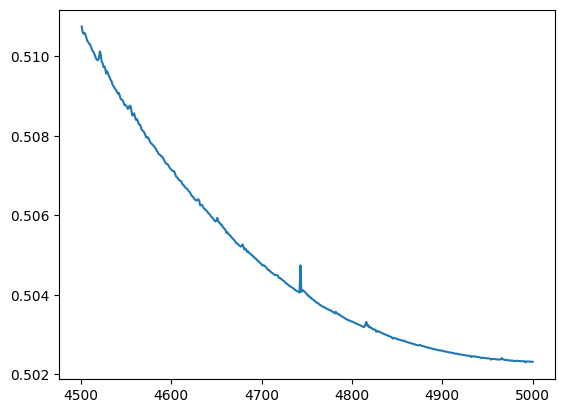

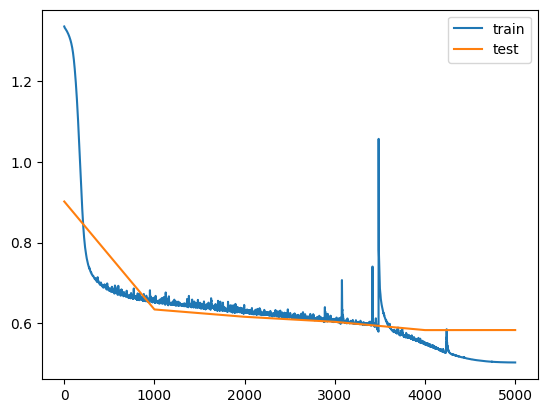

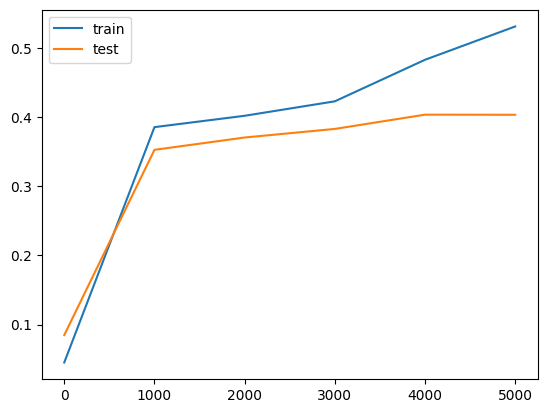

In [7]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

tensor([0.3874, 0.3696, 0.3528, 0.3299, 0.3000, 0.2841, 0.2585, 0.2321, 0.2138,
        0.1978], device='cuda:0')
------
------
tensor([ 0.2790, -0.0702,  0.1905, -0.0917, -0.0315, -0.0358, -0.2594,  0.1516,
        -0.0912, -0.0226], device='cuda:0') tensor([ 0.7358, -0.1783,  0.2084, -0.1460, -0.0494, -0.0780, -0.2736,  0.1997,
        -0.2081, -0.0608], device='cuda:0')
tensor([0.3874, 0.3696, 0.3529, 0.3299, 0.3000, 0.2841, 0.2585, 0.2321, 0.2138,
        0.1978], device='cuda:0')


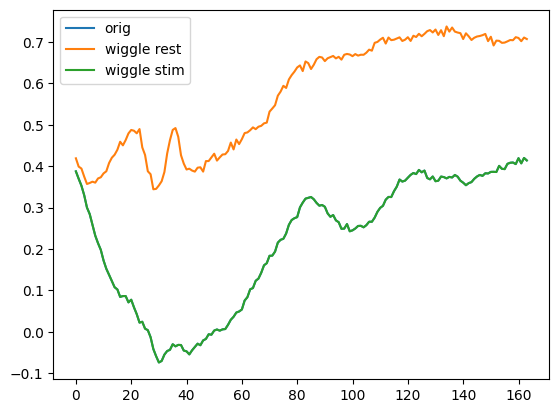

In [10]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150917_Session1_M1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * 2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

In [17]:
print(ms.model.instances['MonkeyG_20150925_Session2_S1'].prev_bases[0])

tensor([[-1.6950, -1.6841, -1.5680,  ...,  1.0476, -1.6124,  1.8581],
        [ 1.5737,  0.8381,  0.6144,  ...,  0.4595, -1.4544, -0.4424],
        [ 1.9009,  0.6420,  0.6892,  ...,  1.8129,  1.1658,  1.8373],
        ...,
        [ 1.4457, -0.6197,  1.1864,  ...,  0.7964, -0.7746,  1.1812],
        [-0.5792, -0.3554,  1.8601,  ..., -0.8813, -0.4835,  1.3485],
        [ 1.0957, -1.2948,  1.0056,  ...,  0.2971, -0.7856,  0.9564]],
       device='cuda:0')


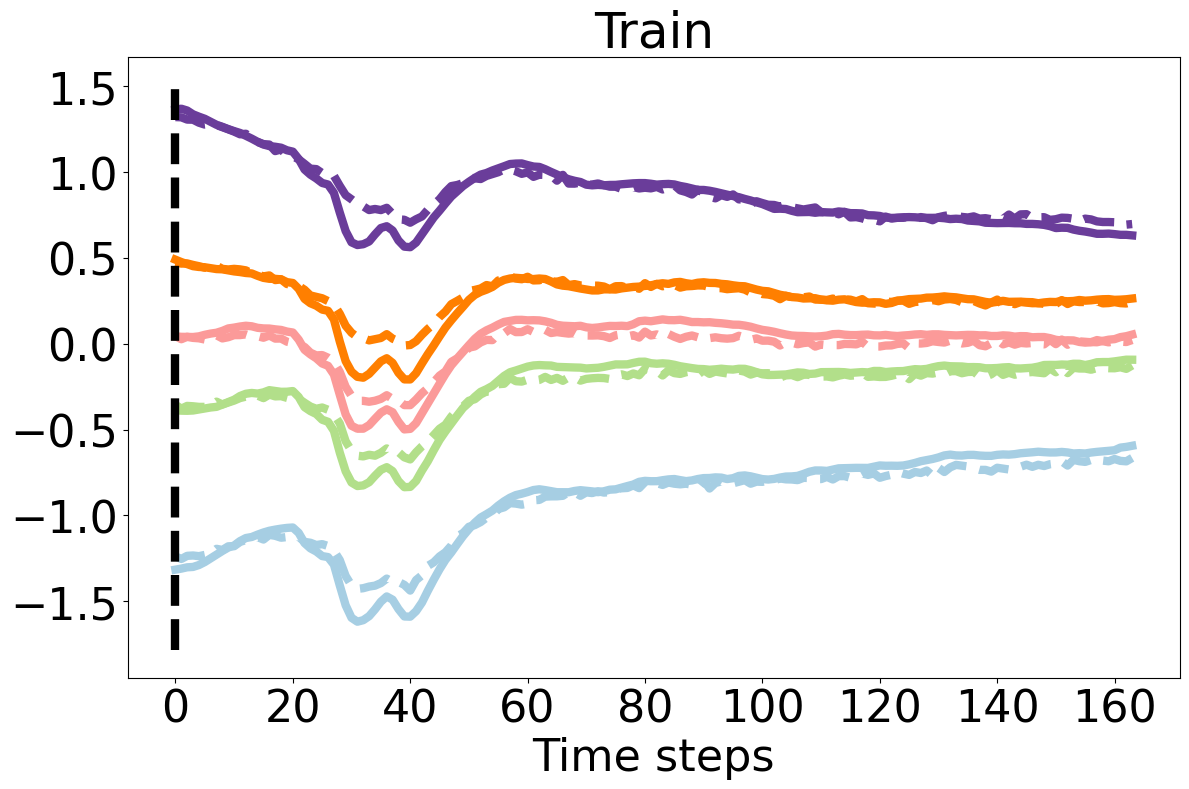

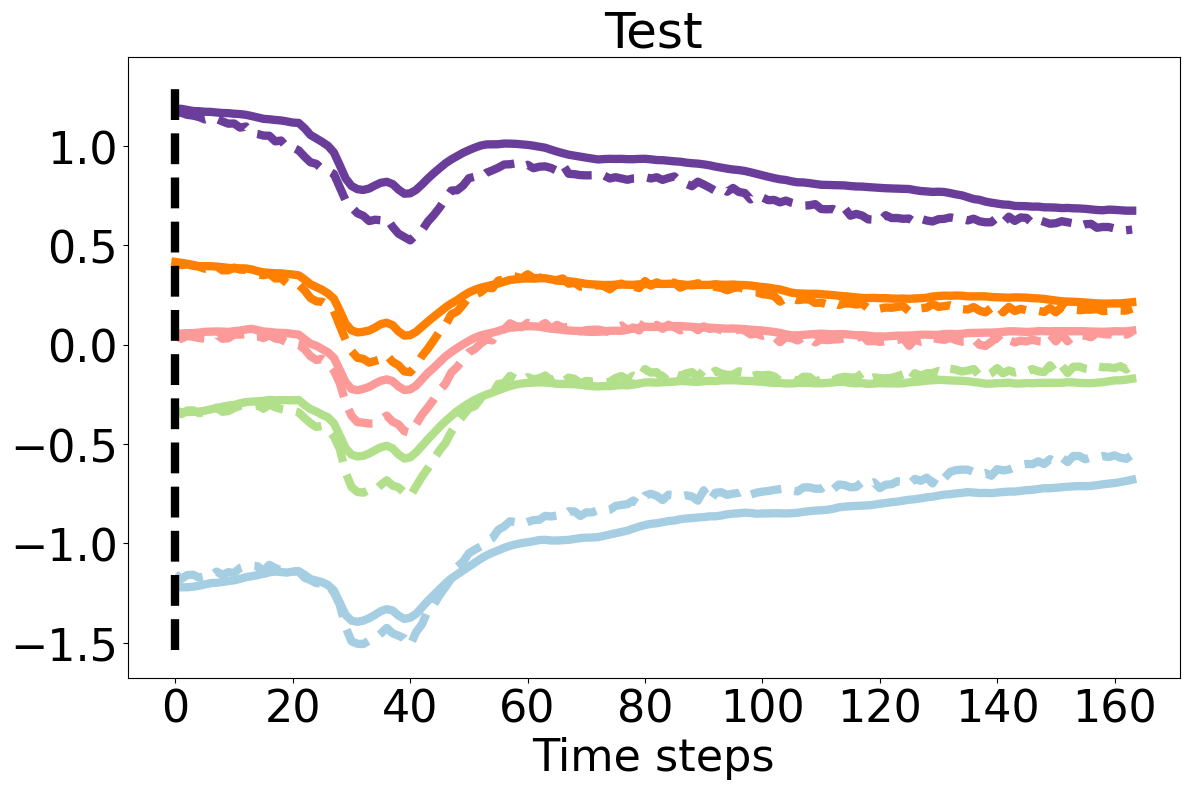

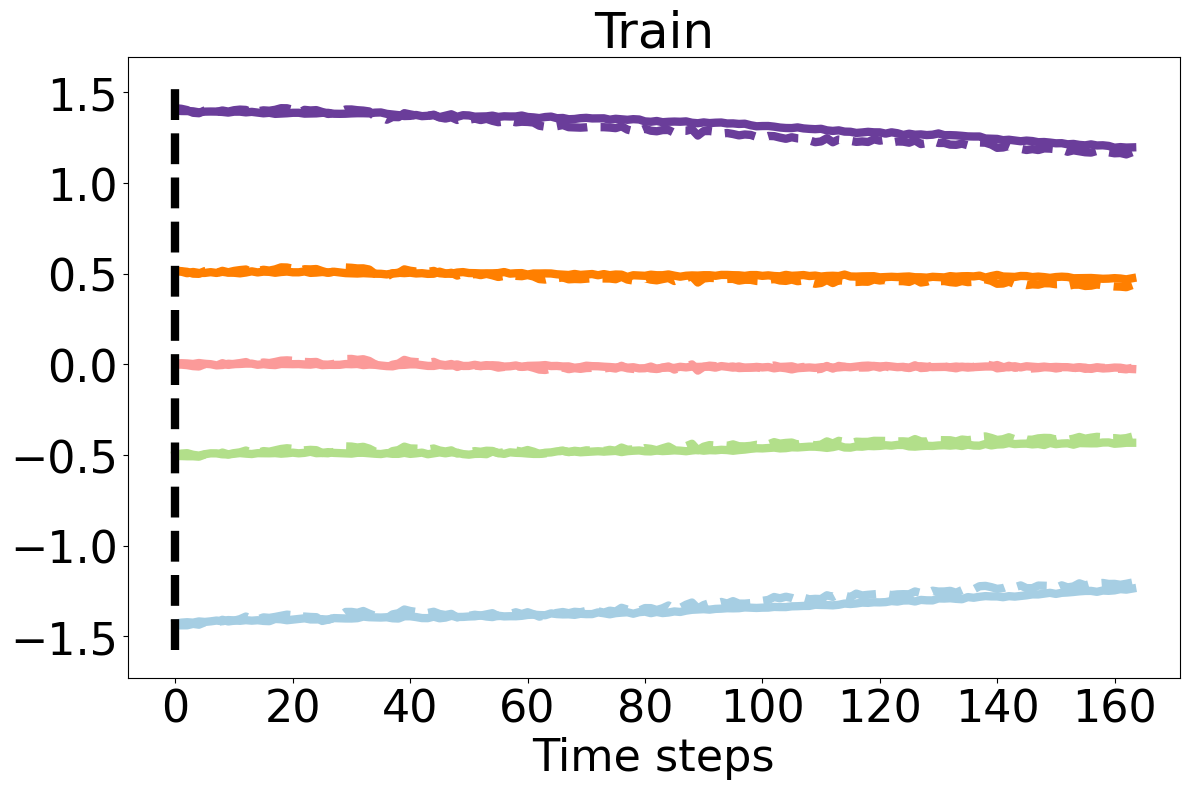

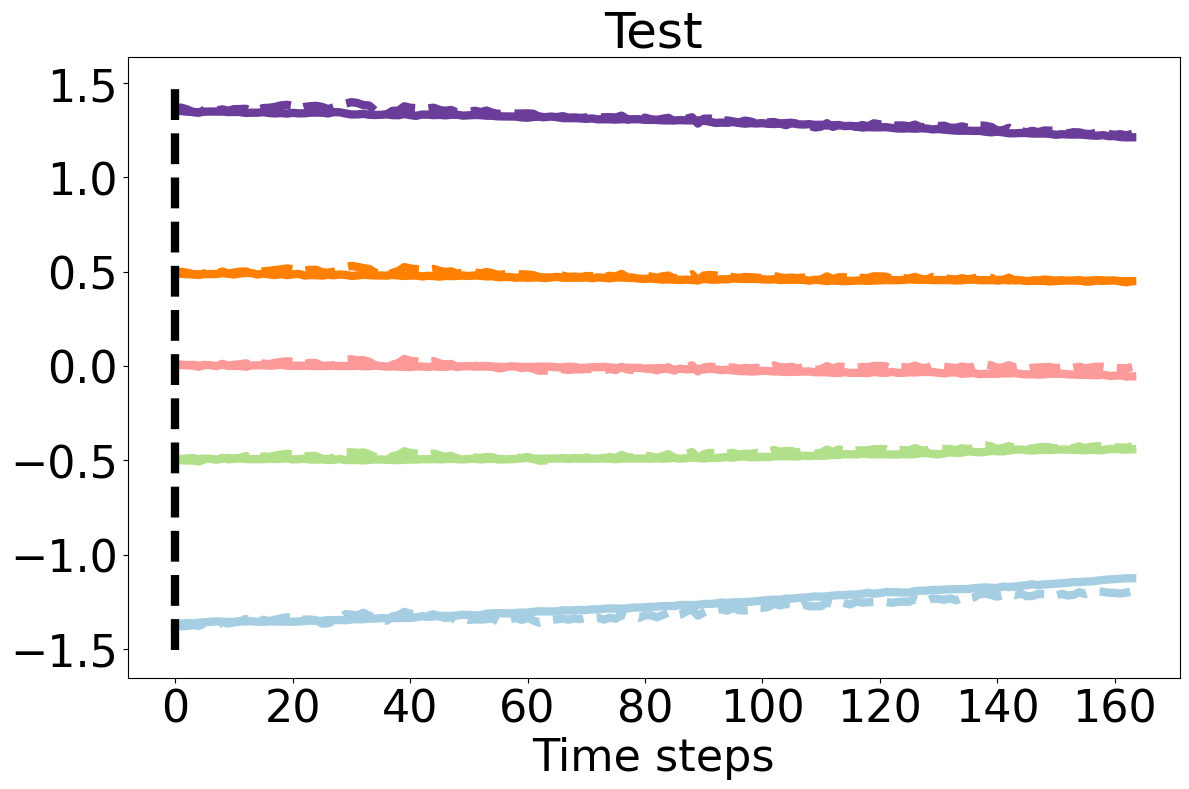

In [10]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    # y_hat_mean = torch.mean(y_hats, dim=0)
    # y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    # y_mean = torch.mean(y, dim=0)
    # y_test_mean = torch.mean(y_test, dim=0)
    
    # bidx = 1000
    
    # plt.plot(y_hat_test_mean[:, cidx], label="hat")
    # plt.plot(y_test_mean[RUNWAY:, cidx], label="y")
    # plt.legend()
    # plt.show()
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
# graph_for_sid('MonkeyG_20150914_Session1_S1', results)

In [33]:
blah = torch.tanh(ms.model.instances[sid].prev_basis_weights[9])
blahs = torch.sum(blah, dim=1)
print(blahs.shape)
print(blahs)

blahn = torch.nn.functional.normalize(blah, p=2, dim=-1)
print(blah.shape, blahn.shape)
print(blahn)

torch.Size([70])
tensor([ 0.3624,  1.3187, -2.8391,  0.9660, -1.0441, -0.9525,  0.7022, -0.0822,
         1.1098,  0.0158,  0.3504, -0.1517, -0.3487, -0.5823, -0.6952, -0.4142,
         0.2541, -1.1497, -1.1219, -0.4731,  0.2360, -0.4768, -0.5137, -0.1212,
        -0.4544, -0.0401, -0.2733,  0.2481, -0.3609, -0.2881, -0.1990,  0.4076,
        -0.9071, -0.5430,  0.4857,  0.7643,  0.5441, -0.1962,  0.1310,  0.2465,
        -1.1134, -0.4256,  0.6031,  0.4499, -1.1188,  0.3667, -0.6012, -0.4048,
         1.4354,  0.5154,  0.7179, -0.1066, -0.6577, -0.3081,  0.0780,  0.5383,
         0.4638,  0.3787, -0.2958,  0.2867, -0.1562, -0.1483,  0.5241,  0.3818,
         0.5556,  0.8531, -0.1996, -0.3095,  0.2297, -0.1108], device='cuda:0',
       grad_fn=<SumBackward1>)
torch.Size([70, 65]) torch.Size([70, 65])
tensor([[-0.1359,  0.1177,  0.0654,  ...,  0.1082, -0.1364, -0.0985],
        [-0.1640,  0.0456,  0.1276,  ...,  0.1349,  0.0088, -0.0881],
        [ 0.2098, -0.1032, -0.1209,  ..., -0.1236,

In [ ]:
# Let's do a test set inference pass so we can look at things.
sid = "MonkeyJ_20160502_Session1_S1"
dt =  utils.move_batch({sid:next(iter(data_train))[sid]}, device=DEVICE)
y_hats = ms(dt)[sid]

print(torch.min(ms.model.instances[sid].prev_basis_weights))
print(torch.max(ms.model.instances[sid].prev_basis_weights))
print(torch.mean(torch.abs(ms.model.instances[sid].prev_basis_weights)))
print(ms.model.instances[sid].prev_basis_weights.shape)

# for cidx in range(70):
#     for idx in range(100):
#         plt.plot(ms.model.instances["MonkeyG_20150925_Session2_S1"].prev_basis_weights[idx, cidx, :].detach().cpu())
#     plt.title(str(cidx))
#     plt.show()

for idx in range(300):
    print(idx, torch.min(ms.model.instances[sid].prev_basis_weights[idx, 0]))

print(ms.model.instances[sid].prev_basis_weights[0, 0, :])
plt.plot(y_hats[0, :, 0].detach().cpu())
plt.plot(dt[sid][2][0, :, 0].detach().cpu(), label="y")
plt.legend()
plt.show()

In [ ]:
# Try:

for regweight in (0.01, 0.05, 0.1):
    for num_bases in (50, 70):
        for lr_head in (1e-4, 2e-4, 3e-4):
            for lambda_ortho in (0.1, 0.2, 0.3):
                print("---------------", regweight, num_bases, lr_head, lambda_ortho)

                if regweight == 0.01 and num_bases == 50 and lr_head == 1e-4 and lambda_ortho == 0.1:
                    print("cont")
                    continue
    
                cfg.tbfm.training.lambda_fro = regweight
                cfg.tbfm.module.num_bases = num_bases
                # cfg.latent_dim = latent_dim
                cfg.tbfm.training.optim.lr_head = lr_head
                cfg.tbfm.training.lambda_ortho = lambda_ortho
                cfg.tbfm.module.use_film_bases = False
                cfg.ae.training.coadapt = True
                cfg.training.epochs = 20001
    
                ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
                model_optims = multisession.get_optims(cfg, ms)
                
                embeddings_stim, results = multisession.train_from_cfg(
                    cfg,
                    ms,
                    data_train,
                    model_optims,
                    embeddings_rest,
                    data_test=data_test,
                    test_interval=5000,
                    epochs=20001,
                    # grad_clip=grad_clip
                    )
                torch.save(results, f"res_{regweight}_{num_bases}_{lr_head}_{lambda_ortho}.torch")

                del model_optims, ms

--------------- 0.01 50 0.0001 0.1
cont
--------------- 0.01 50 0.0001 0.2
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.0459461212158203 1.0695467525058322 -0.14217583185993135 -0.1299773148364491
basis_weighting.weight         grad_norm=1.5822e-01, weight_norm=2.6364e+00, ratio=6.0013e-02
basis_weighting.bias           grad_norm=2.9303e-03, weight_norm=3.6951e+01, ratio=7.9302e-05
bases.in_layer.weight          grad_norm=9.0766e-07, weight_norm=1.6268e+00, ratio=5.5796e-07
bases.in_layer.bias            grad_norm=1.1477e-07, weight_norm=6.1941e-02, ratio=1.8529e-06
bases.hiddens.0.weight         grad_norm=2.1465e-04, weight_norm=1.1931e+00, ratio=1.7990e-04
bases.hiddens.0.bias           grad_norm=1.0745e-04, weight_norm=5.2824e-01, ratio=2.0340e-04
bases.hiddens.1.weight         grad_norm=3.0949e-04, weight_norm=1.4401e+00, ratio=2.1491e-04
bases.hiddens.1.bias           grad_norm=2.2490e-04, weight_norm=5.8521e-01, r

In [10]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# (0.4557589888572693, './res_0.07_17_70_10.0.torch')
# (0.4561246633529663, './res_0.05_12_50_10.0.torch')
# (0.45635348558425903, './res_0.01_17_70_10.0.torch')
# (0.4564235210418701, './res_0.07_17_70_1000.torch')
# (0.4569217562675476, './res_0.05_17_50_10.0.torch')
# (0.45701655745506287, './res_0.05_17_50_1000.torch')
# (0.4574051797389984, './res_0.05_20_70_1000.torch')
# (0.4576779007911682, './res_0.05_15_50_1000.torch')
# (0.45774632692337036, './res_0.05_15_70_1000.torch')
# (0.4579020142555237, './res_0.05_17_70_10.0.torch')

# Fro 0.05
# num_bases 17
# latent dim 70
# clip_grad None

(0.35666774378882515, './res_0.05_50_0.0003_0.2.torch')
(0.35697651902834576, './res_0.01_70_0.0003_0.3.torch')
(0.3569850954744551, './res_0.01_70_0.0001_0.1.torch')
(0.35736728376812404, './res_0.01_70_0.0001_0.3.torch')
(0.357471548848682, './res_0.01_50_0.0003_0.1.torch')
(0.35761067602369523, './res_0.01_70_0.0002_0.2.torch')
(0.35779477490319145, './res_0.01_70_0.0003_0.2.torch')
(0.3578372299671173, './res_0.01_70_0.0003_0.1.torch')
(0.35784753163655597, './res_0.01_50_0.0003_0.2.torch')
(0.357981413602829, './res_0.01_70_0.0002_0.1.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}
